# Random Forest

Solve for the Titanic Survivors Prediction Kaggle competition usind Random Forest Classifier.

Dataset can be obtained <a href="https://www.kaggle.com/c/titanic/data" target="_blank">here</a>.

## Libraries

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Importing and checking the data

In [2]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that there is a lot o missing data for Age and Cabin. We'll leave it as is, since this columns won't be used in our predictive model.

In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Data Exploration

Before going into our model, let's see what we can discover from all the data we got. First, lets see the percentage of the survivors.

In [127]:
total_survived = sum(train['Survived'])/len(train)
print(f'{total_survived*100:.2f}% of the people on the ship survived.')

women = train.loc[train.Sex == 'female']
women_survived = sum(women['Survived'])/(len(women))
print(f'{women_survived*100:.2f}% of the women survived.')

men = train.loc[train.Sex == 'male']
men_survived = sum(man['Survived']/len(man))
print(f'{men_survived*100:.2f}% of the men survived.')

children = train.loc[train.Age < 18]
children_survived = sum(children['Survived'])/len(children)
print(f'{children_survived*100:.2f} of the children survived.')

38.38% of the people on the ship survived.
74.20% of the women survived.
18.89% of the men survived.
53.98 of the children survived.


Note: children (age<18) are also included on men and women data.

We got the percentages, but we can also show it with some plots.

[Text(0.5, 1.0, 'Children'), Text(0.5, 0, ''), Text(0, 0.5, '')]

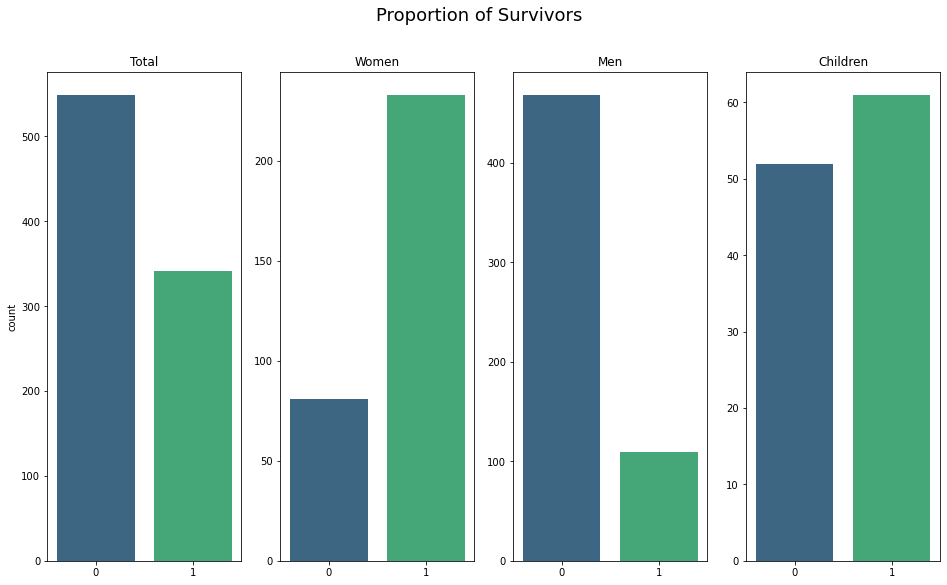

In [175]:
plt.figure(1, figsize=(16,9))
plt.suptitle('Proportion of Survivors', fontsize = 18)

plt.subplot(1,4,1)
sns.countplot(x='Survived', data = train, palette = 'viridis').set(title = 'Total', xlabel = None)

plt.subplot(1,4,2)
sns.countplot(x='Survived', data = women, palette = 'viridis').set(title = 'Women', xlabel = None, ylabel = None)

plt.subplot(1,4,3)
sns.countplot(x='Survived', data = men, palette = 'viridis').set(title = 'Men', xlabel = None, ylabel = None)

plt.subplot(1,4,4)
sns.countplot(x='Survived', data = children, palette = 'viridis').set(title = 'Children', xlabel = None, ylabel = None)


Now, let's see how age relates to the survivors. 

In [193]:
group_total = train[train.Survived == 1]
group_women = women[women.Survived == 1]
group_men = men[men.Survived == 1]
group_children = children[children.Survived == 1]

Text(0.5, 0, 'Age')

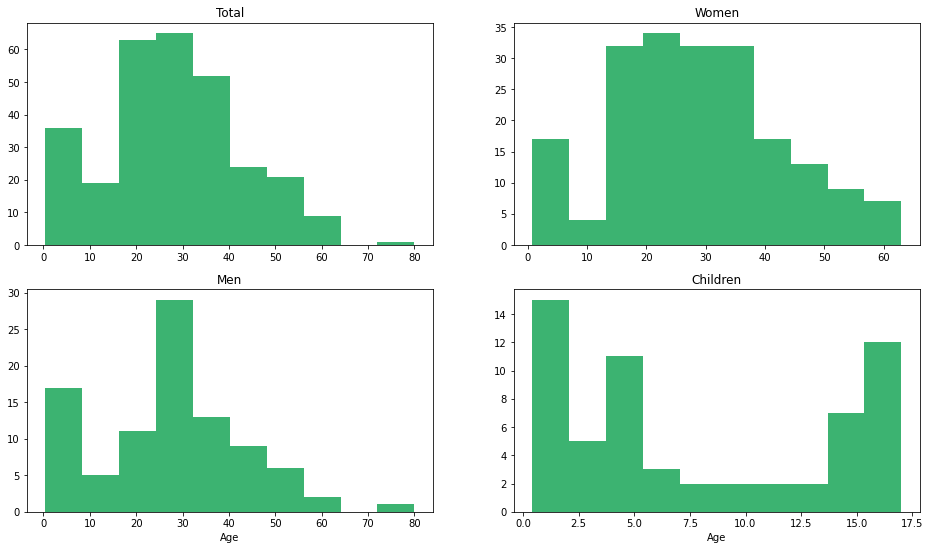

In [197]:
plt.figure(1, figsize = (16,9))

plt.subplot(2,2,1)
plt.hist(group_total.iloc[:,5].dropna(), color = 'mediumseagreen')
plt.title('Total')

plt.subplot(2,2,2)
plt.hist(group_women.iloc[:,5].dropna(), color = 'mediumseagreen')
plt.title('Women')

plt.subplot(2,2,3)
plt.hist(group_men.iloc[:,5].dropna(), color='mediumseagreen')
plt.title('Men')
plt.xlabel('Age')

plt.subplot(2,2,4)
plt.hist(group_children.iloc[:,5].dropna(), color='mediumseagreen')
plt.title('Children')
plt.xlabel('Age')

As we can see, younger adults were the main ones that survived, especially women. Among children, teenagers and newborns survived most.

Now, let's create our predictive model.

### Random Forest Classifier

First, we define our variables, get dummies, since 'sex' is a categorical column, and split them between trainning and testing. After a few tests, I decided to go with 'Pclass', 'Sex', 'SibSp', 'Parch' and 'Fare', since it was the higher accuracy I could get.

In [206]:
y = train['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
x = pd.get_dummies(train[features])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

Now we create de model and fit the data.

In [207]:
forest = RandomForestClassifier(n_estimators = 100, max_depth=100, random_state=1)
forest.fit(x,y)

RandomForestClassifier(max_depth=100, random_state=1)

Now we can see the results, whith our confusion matrix and the accuracy obtained with the test data.

In [208]:
predict = forest.predict(x_test)
confusion = confusion_matrix(y_test,predict)
print(confusion)
accuracy = accuracy_score(y_test,predict)
print(accuracy)

[[159   9]
 [  9  91]]
0.9328358208955224


## Prediction with the new data

First, we import our new data and check for non availabe data. 

In [210]:
test_data = pd.read_csv('test.csv')
x_test_data = pd.get_dummies(test_data[features])
x_test_data.isna().sum()

Pclass        0
SibSp         0
Parch         0
Fare          1
Sex_female    0
Sex_male      0
dtype: int64

There's one missing value on our new dataset and we need to fill it for our prediction model to work. Here, I chose to use the median of the values, since the mean feels too high and the mode too low.

In [15]:
x_test_data.fillna(test_data['Fare'].median(), inplace = True)
x_test_data.isna().sum()

Pclass        0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
dtype: int64

Now that we have all the values, we can run the model.

In [16]:
x_test_data.isna().sum()
results = forest.predict(x_test_data)
results

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Last thing we need to do is to write the results on an .csv file, which will be submitted to kaggle for us to see how accurate our model was.

In [36]:
output_forest = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': results})
output_forest.to_csv('output_forest.csv', index=False)
print(output_forest.shape)
output_forest.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Conclusion

The model got an accuracy of 0.75119, which is fairly lower than I expected. As I improve my skills, I'll probable update this software to get a better result.